In [2]:
import os

os.listdir('.')

['.git',
 '.ipynb_checkpoints',
 'histopathologic-cancer-detection',
 'histopathologic-cancer-detection.zip',
 'solution.ipynb']

# Read in a sample image

(96, 96, 3)


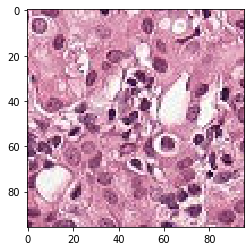

In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import imageio


image = imageio.imread(
    'histopathologic-cancer-detection/train/{0}'.format(
        os.listdir('histopathologic-cancer-detection/train')[0]
    )
)
print(image.shape)
plt.imshow(image)


# Define a batch generator

While I disagree with this batch generator being run line by line, as per the TensorFlow documentation, I do appreciate the fact that this is done in parallel with the training.

In [1]:
import imageio
import numpy as np
import os
import pandas as pd

def batch_generator(labels_file_path, images_folder_path, batch_size):
    image_files = np.asarray(
        os.listdir(images_folder_path)
    )
    labels = pd.read_csv(labels_file_path)
    while True:
        label_rows = labels.sample(batch_size)
        onehot_vectors = np.zeros((batch_size, 2))
        onehot_vectors[label_rows['label'] == 1, 1] = 1
        onehot_vectors[label_rows['label'] == 0, 0] = 1
        training_data = np.intersect1d(
            image_files,
            label_rows['id'].apply(lambda hash: hash + '.tif'),
            assume_unique=True
        )
        image_data = np.asarray(
            [imageio.imread('histopathologic-cancer-detection/train/{0}'.format(filename)) for filename in training_data]
        )
        yield (image_data / 255, onehot_vectors)

# Define a model

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

model = Sequential()
# Convolution layer 1
model.add(
    Conv2D(
        1024,
        kernel_size=(3, 3),
        input_shape=(96, 96, 3),
        data_format='channels_last'
    )
)
model.add(
    MaxPooling2D(pool_size=(2, 2)) # (46, 46, 3)
)
# Convolution layer 2
model.add(
    Conv2D(512, (3, 3))
)
model.add(
    MaxPooling2D(pool_size=(2, 2)) # (23, 23, 3)
)

# Convolution layer 3
model.add(
    Conv2D(256, (3, 3))
)
model.add(
    MaxPooling2D(pool_size=(2, 2)) # (11, 11, 3)
)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

model.fit_generator(
    batch_generator(
        'histopathologic-cancer-detection/train_labels.csv',
        'histopathologic-cancer-detection/train/',
        32
    ),
    steps_per_epoch=5000,
    epochs=10
)

Epoch 1/10
 161/5000 [..............................] - ETA: 30:54 - loss: 9.7465 - acc: 0.3921